Behavioral Cloning Project - Driving Simulator

In [1]:
import csv
import cv2
import numpy as np
from tqdm import tqdm   #Library for progress bar on for loops.

#Read in the csv file.
lines = []
with open('../data/driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(csvfile)                       #Skip the header
    for line in reader:
        lines.append(line)

correction = 0.3  #Hyperparameter to tune
        
#Filling X_train and y_train        
images = []
measurements = []
for line in tqdm(lines):
    #Center camera
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)    
    
    #Left camera
    source_path = line[1]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement + correction)
    
    #Right camera
    source_path = line[2]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement - correction)


print(len(images))
print(len(measurements))
print(np.count_nonzero(np.array(measurements))) #This is a measure of the quality of the training data. The higher the better.

100%|██████████| 8036/8036 [00:42<00:00, 190.73it/s]

24108
24108
19747


In [2]:
from cv2 import resize
resized_images = []
for image in tqdm(images):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    resized_images.append(cv2.resize(image,dsize=(128,64)))

print(len(resized_images))

100%|██████████| 24108/24108 [00:14<00:00, 1608.47it/s]

24108


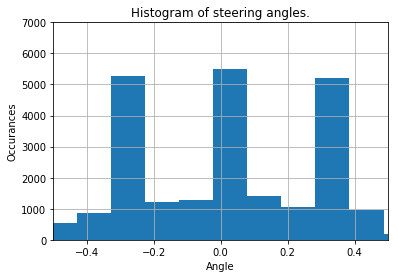

In [3]:
#Histogram of steering angles.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# the histogram of the data
n, bins, patches = plt.hist(measurements, 25)

plt.xlabel('Angle')
plt.ylabel('Occurances')
plt.title('Histogram of steering angles.')
plt.axis([-.5, .5, 0, 7000])
plt.grid(True)

plt.show()
#Much more lefthand turning.

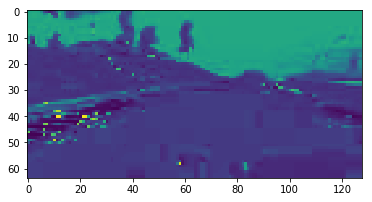

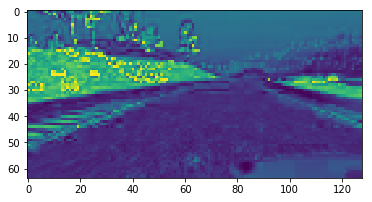

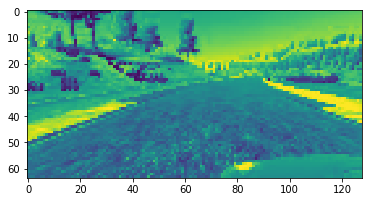

In [5]:
image_number = 4549
h,s,v = cv2.split(resized_images[image_number])
plt.imshow(h)
plt.figure()
plt.imshow(s)
plt.figure()
plt.imshow(v)

In [21]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(resized_images,measurements):
    augmented_images.append(image[:,:,1])
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image[:,:,1],1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2],1))
#X_train = X_train.reshape((64, 128,1))
print(X_train.shape)
print(y_train.shape)

(48216, 64, 128, 1)
(48216,)


This image is: <class 'numpy.ndarray'> with dimensions: (64, 128, 1)
Steering angle:  0.0787459


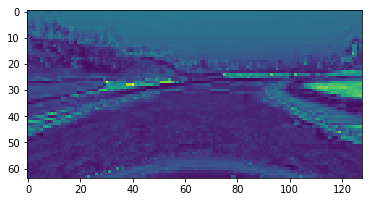

In [24]:
#Plotting an image and its flipped counterpart w/steering angles.
#image_number = 9900 #Good image for MY data.
image_number = 4549 #Good image for UDACITY data.


#printing out some stats and plotting
print('This image is:', type(X_train[image_number]), 'with dimensions:', X_train[image_number].shape)
print('Steering angle: ',y_train[image_number])
plt.imshow(X_train[image_number][:,:,0])

Steering angle:  0.2212541


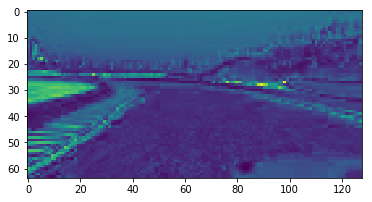

In [25]:
#Flipped image
plt.imshow(X_train[image_number+1][:,:,0])
print('Steering angle: ',y_train[image_number+1])

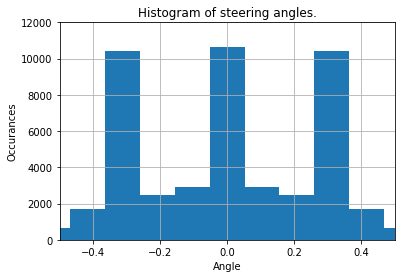

In [26]:
#Histogram of steering angles.

# the histogram of the data
n, bins, patches = plt.hist(y_train, 25)

plt.xlabel('Angle')
plt.ylabel('Occurances')
plt.title('Histogram of steering angles.')
plt.axis([-.5, .5, 0, 12000])
plt.grid(True)

plt.show()
#Much better-looking distribution.

In [29]:
#Build the Model
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Cropping2D
from keras.layers import Activation, Dropout, ZeroPadding2D
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,128,1)))
model.add(Cropping2D(cropping=((25,10), (0,0))))

#Original code:
#model.add(Conv2D(24, (5, 5), padding='same', activation='relu', kernel_constraint=maxnorm(3)))

model.add(Conv2D(24, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(36, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(48, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
#model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
#model.add(Dropout(0.5))
#model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
#model.add(Dropout(0.5))

model.add(Flatten())
#model.add(Dense(100,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(50,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1))

#Use if continuing training from a previous checkpoint.
#model.load_weights("../model_behavioral_cloning_7_1-00.h5")

model.compile(loss ='mse', optimizer='adam')

filepath="../model_behavioral_cloning_13_1-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

#Print out a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 64, 128, 1)        0         
_________________________________________________________________
cropping2d_8 (Cropping2D)    (None, 29, 128, 1)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 128, 24)       624       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 64, 24)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 64, 24)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 64, 36)        21636     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 32, 36)         0         
__________

In [30]:
#Train the Model
history_object = model.fit(X_train,y_train,validation_split=0.2,shuffle=True, epochs=10,batch_size=512,callbacks=callbacks_list)

Train on 38572 samples, validate on 9644 samples
Epoch 1/10
28160/38572 [====================>.........] - ETA: 107s - loss: 0.0699

KeyboardInterrupt: 

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()